# Reward Shaping Demo
The goal of this notebook is to apply concepts of reward shaping to more efficiently solve Markov Decision Processes (MDPs). We will see that:

1. A well-designed potential function **accelerates** solving the MDP, leading to the agent reaching its goal faster.
2. A poorly-designed potential function **slows** solving the MDP, leading to the agent reaching its goal slower.
3. Reward shaping that is not a potential function may result in **not solving** the MDP, leading to convergence to the wrong value.

## Grid world, revisited
We will revisit the grid world, but now with more states, to make the problem harder. A few items to note:
- An episode terminates when the agent reaches a goal state, either good (+1) or bad (-1).
- By default, Q-learning will run for 100 episodes. How much can the agent learn in 100 episodes?
- We should expect a random walk from the lower left corner to the top right corner to take a while, especially for large grids.
- In comparison, with sufficient "fake rewards" that nudge the agent in the right direction, we should expect an agent with a shaped reward to quickly find a short path to the good goal state - regardless of how big the grid is.
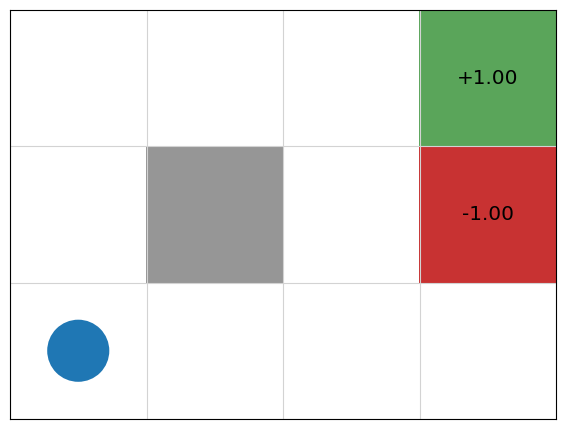

## A good potential function

To implement potential-based reward shaping, we need to first implement a potential function. We implement potential functions as subclasses of ``PotentialFunction``. For the GridWorld example, the potential function is 1 minus the normalised distance from the goal:

In [1]:
import random
random.seed(1392020)

import os
import sys
directory_path = os.path.abspath(os.path.join('..'))
if directory_path not in sys.path:
    sys.path.append(directory_path)

from rl_notes.gridworld import GridWorld
from rl_notes.potential_function import PotentialFunction


class GridWorldPotentialFunction(PotentialFunction):
    def __init__(self, mdp):
        self.mdp = mdp

    def get_potential(self, state):
        if state != GridWorld.TERMINAL:
            goal = (self.mdp.width, self.mdp.height)
            x = 0
            y = 1
            return 0.1 * (
                1 - ((goal[x] - state[x] + goal[y] - state[y]) / (goal[x] + goal[y]))
            )
        else:
            return 0.0

Reward shaping for Q-learning is then a simple extension of the ``QLearning`` class, overriding the ``update`` method:

In [2]:
from model_free_reinforcement_learner import ModelFreeReinforcementLearner
from qlearning import QLearning


class RewardShapedQLearning(QLearning):
    def __init__(self, mdp, bandit, potential, qfunction, alpha=0.1):
        super().__init__(mdp, bandit, qfunction=qfunction, alpha=alpha)
        self.potential = potential

    def get_delta(self, reward, q_value, state, next_state, next_action):
        next_state_value = self.state_value(next_state, next_action)
        state_potential = self.potential.get_potential(state)
        next_state_potential = self.potential.get_potential(next_state)
        potential = self.mdp.discount_factor * next_state_potential - state_potential
        delta = reward + potential + self.mdp.discount_factor * next_state_value - q_value
        return delta

We can run this on a GridWorld example with more states:

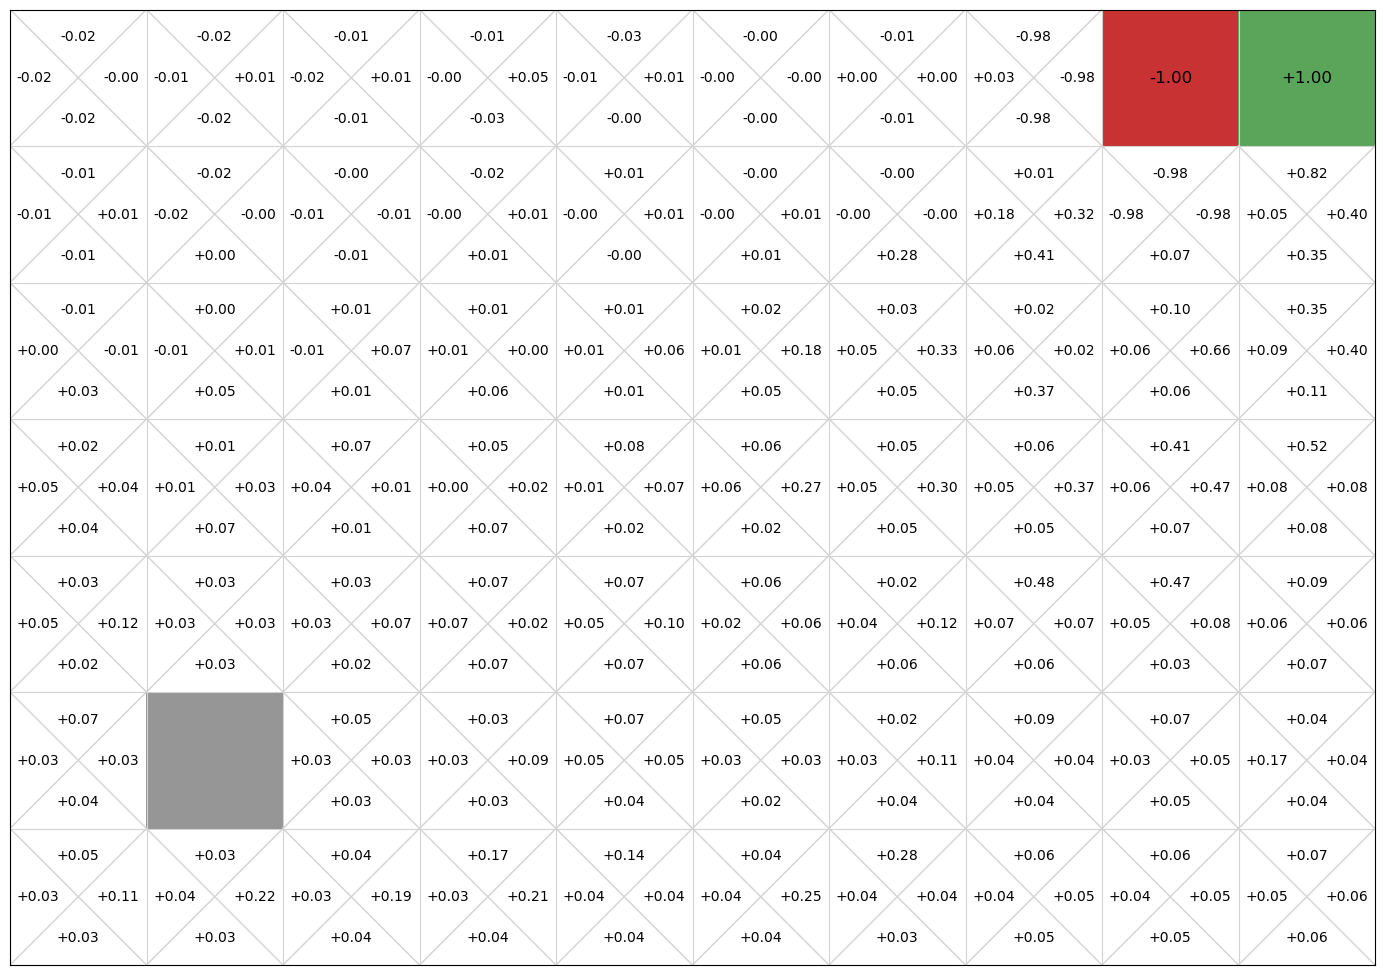

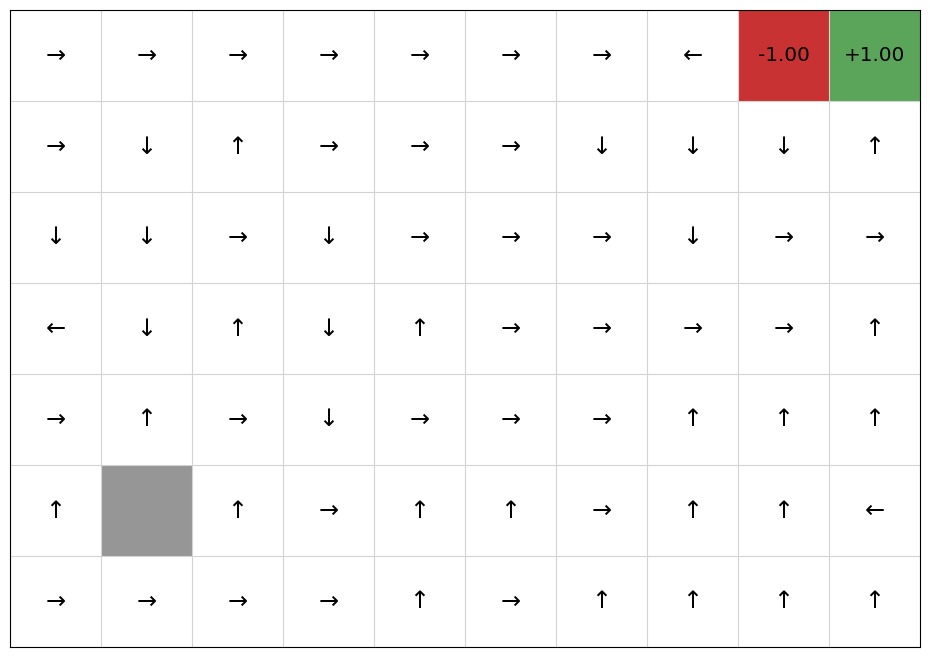

In [3]:
from qtable import QTable
from qlearning import QLearning
from reward_shaped_qlearning import RewardShapedQLearning
from gridworld_potential_function import GridWorldPotentialFunction
from multi_armed_bandit.epsilon_greedy import EpsilonGreedy


mdp = GridWorld(width = 10, height = 7, goals = [((9,6), 1), ((8,6), -1)])
qfunction = QTable()
potential = GridWorldPotentialFunction(mdp)
RewardShapedQLearning(mdp, EpsilonGreedy(), potential, qfunction).execute()
# RewardShapedQLearning(mdp, EpsilonGreedy(), potential, qfunction).execute(visualize=True)
policy = qfunction.extract_policy(mdp)
mdp.visualise_q_function(qfunction)
mdp.visualise_policy(policy)
reward_shaped_rewards = mdp.get_rewards()

Now, we compare this with Q-learning without reward shaping. Notice that many updates to the Q function yield no change from the initial Q function (all zeros). Why is this?

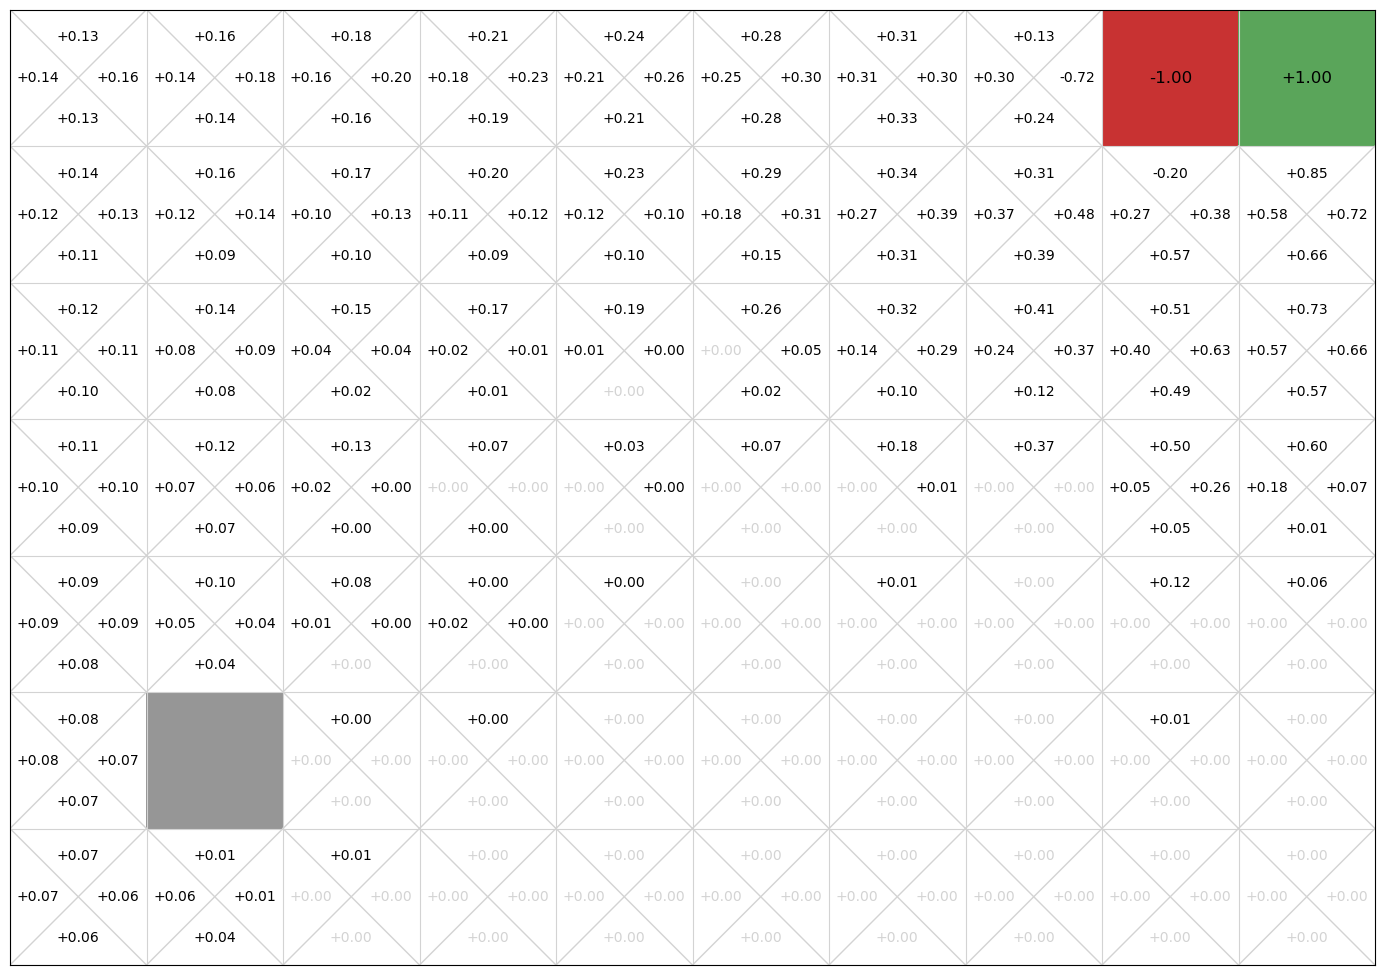

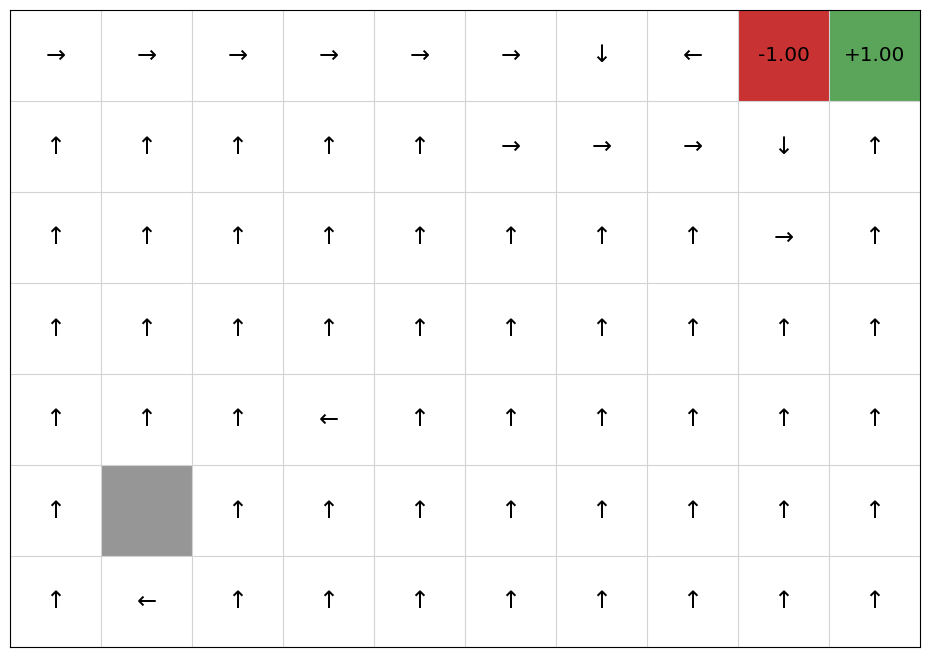

In [4]:
# mdp = GridWorld(width = 15, height = 12, goals = [((14,11), 1), ((13,11), -1)])
mdp = GridWorld(width = 10, height = 7, goals = [((9,6), 1), ((8,6), -1)])
qfunction = QTable()
QLearning(mdp, EpsilonGreedy(), qfunction).execute()
policy = qfunction.extract_policy(mdp)
mdp.visualise_q_function(qfunction)
mdp.visualise_policy(policy)
q_learning_rewards = mdp.get_rewards()

If we plot the average episode length during training, we see that reward shaping reduces the length of the early episodes because it has knowledge nudging it towards the goal:

In [5]:
import matplotlib.pyplot as plt

class Plot:
    @staticmethod
    def plot_episode_length(labels, data):
        # Assuming 'data' is a list of lists with per-step rewards as floats
        # And 'labels' is a list of the names of the strategies

        # Check if 'labels' and 'data' lengths match
        if len(labels) != len(data):
            raise ValueError("Labels and data must have the same length")

        # Set the background color
        plt.figure(facecolor='whitesmoke')
        ax = plt.axes()
        
        # Setting the background color of the
        # plot using set_facecolor() method
        ax.set_facecolor("gainsboro")

        # Plotting each strategy
        for i, sublist in enumerate(data):
            epsiode_length = [len(subsublist) for subsublist in sublist]
            iterations = range(len(sublist))
            plt.plot(iterations, epsiode_length, label=labels[i])

        plt.xlabel('Episode')
        plt.ylabel('Episode length')
        plt.title('Episode Length Over Time')
        plt.legend()
        
        # Add gridlines
        plt.grid(True, color="white")
        
        plt.show()

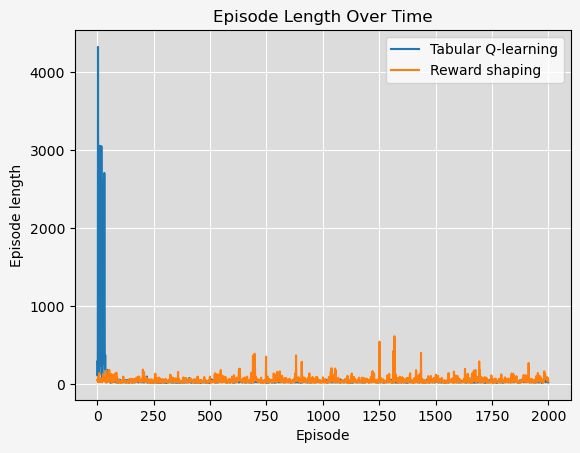

In [6]:
# from tests.plot import Plot

Plot.plot_episode_length(
    ["Tabular Q-learning", "Reward shaping"],
    [q_learning_rewards, reward_shaped_rewards],
)

## A bad potential function
Consider a bad potential function, that nudges the agent in exactly the opposite direction of the 'good' potential function above.

In [7]:
# Return the opposite of the good potential function
class BadGridWorldPotentialFunction(GridWorldPotentialFunction):
    def get_potential(self, state):
        return -super().get_potential(state)

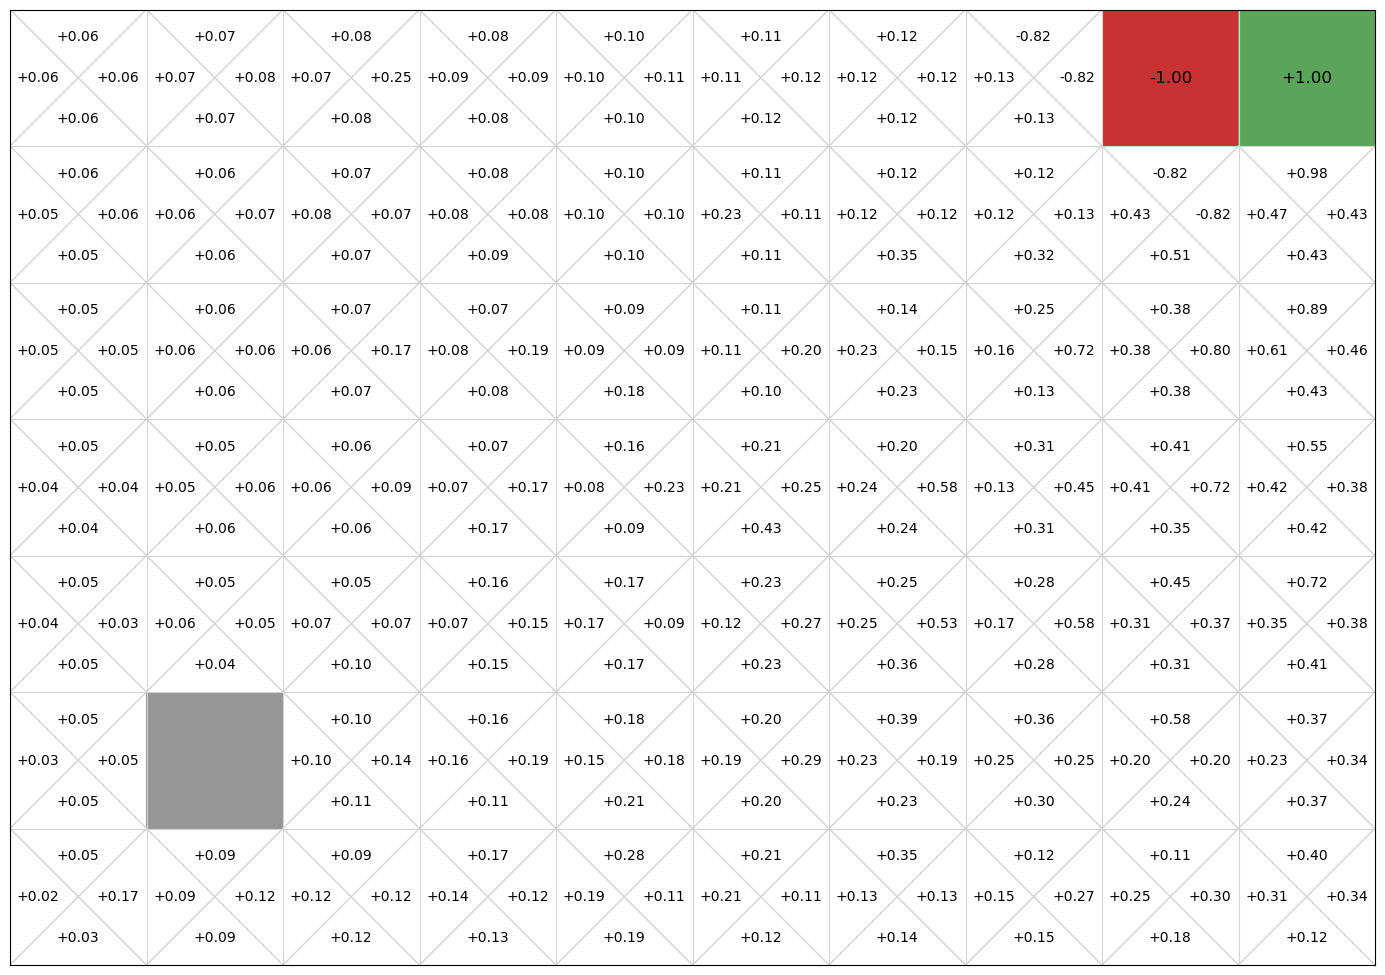

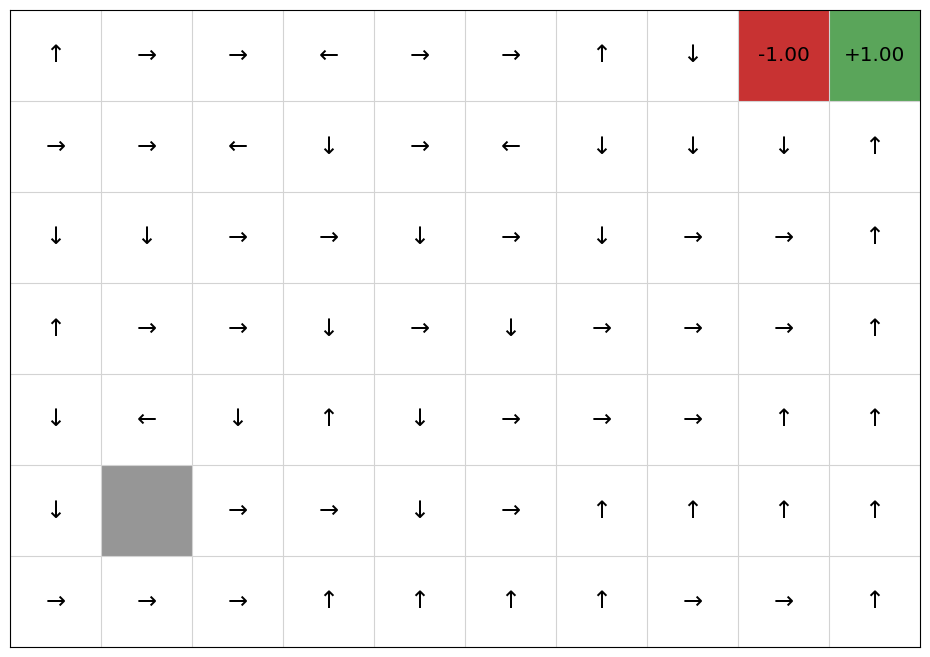

In [8]:
mdp = GridWorld(width = 10, height = 7, goals = [((9,6), 1), ((8,6), -1)])
qfunction = QTable()
potential = BadGridWorldPotentialFunction(mdp)
RewardShapedQLearning(mdp, EpsilonGreedy(), potential, qfunction).execute()
policy = qfunction.extract_policy(mdp)
mdp.visualise_q_function(qfunction)
mdp.visualise_policy(policy)
bad_reward_shaped_rewards = mdp.get_rewards()

Examining the episode lengths, we can see that the agent learns the shortest path even more slowly than providing no information to the agent at all!

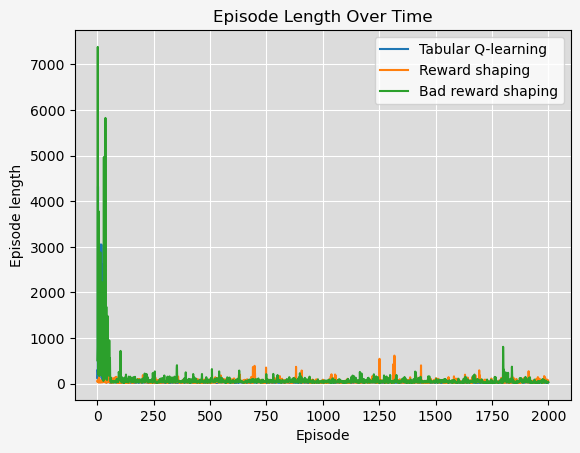

In [9]:
# from tests.plot import Plot

Plot.plot_episode_length(
    ["Tabular Q-learning", "Reward shaping", "Bad reward shaping"],
    [q_learning_rewards, reward_shaped_rewards, bad_reward_shaped_rewards],
)

## Non-potential-based reward shaping (a.k.a., reward tuning)
Reward tuning can be a highly effective strategy because it provides the designer with full flexibility to encode expert domain knowledge into the reward function. The following example provides a cautionary tale.

In [10]:
from model_free_reinforcement_learner import ModelFreeReinforcementLearner
from qlearning import QLearning


class RewardTunedQLearning(QLearning):
    def __init__(self, mdp, bandit, tuning, qfunction, alpha=0.1):
        super().__init__(mdp, bandit, qfunction=qfunction, alpha=alpha)
        self.tuning = tuning

    def get_delta(self, reward, q_value, state, next_state, next_action):
        next_state_value = self.state_value(next_state, next_action)
        tuning = self.tuning.get_tuning(state, next_state, self.mdp.discount_factor)
        delta = reward + tuning + self.mdp.discount_factor * next_state_value - q_value
        return delta

To see that reward tuning is strictly more general than reward shaping, we can implement the earlier potential-based reward function as reward tuning:

In [11]:
# Return the opposite of the good potential function
class PotentialFunctionRewardTuning(GridWorldPotentialFunction):
    def get_tuning(self, state, next_state, discount_factor):
        return discount_factor * super().get_potential(next_state) - super().get_potential(state)

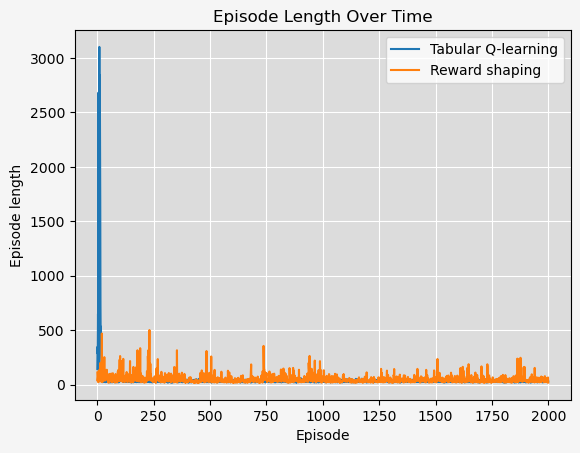

In [12]:
mdp = GridWorld(width = 10, height = 7, goals = [((9,6), 1), ((8,6), -1)])
qfunction = QTable()
tuning = PotentialFunctionRewardTuning(mdp)
RewardTunedQLearning(mdp, EpsilonGreedy(), tuning, qfunction).execute()
policy = qfunction.extract_policy(mdp)
reward_shaped_rewards = mdp.get_rewards()

mdp = GridWorld(width = 10, height = 7, goals = [((9,6), 1), ((8,6), -1)])
qfunction = QTable()
QLearning(mdp, EpsilonGreedy(), qfunction).execute()
policy = qfunction.extract_policy(mdp)
q_learning_rewards = mdp.get_rewards()

Plot.plot_episode_length(
    ["Tabular Q-learning", "Reward shaping"],
    [q_learning_rewards, reward_shaped_rewards],
)

However, we can also implement non-potential-based reward functions. The following (small!) reward tuning introduces a reward loop.

In [13]:
# Return the opposite of the good potential function
class NotAPotentialFunction(GridWorldPotentialFunction):
    def get_tuning(self, state, next_state, discount_factor):
        default = discount_factor * super().get_potential(next_state) - super().get_potential(state)
        tune_states = [(0,0), (1,0), (2,0), (2,1), (2,2), (1,2), (0,2), (0,1)]
        for s,s_next in zip(tune_states, tune_states[1:] + [tune_states[0]]):
            if state == s and next_state == s_next:
                default += 0.05
        return default

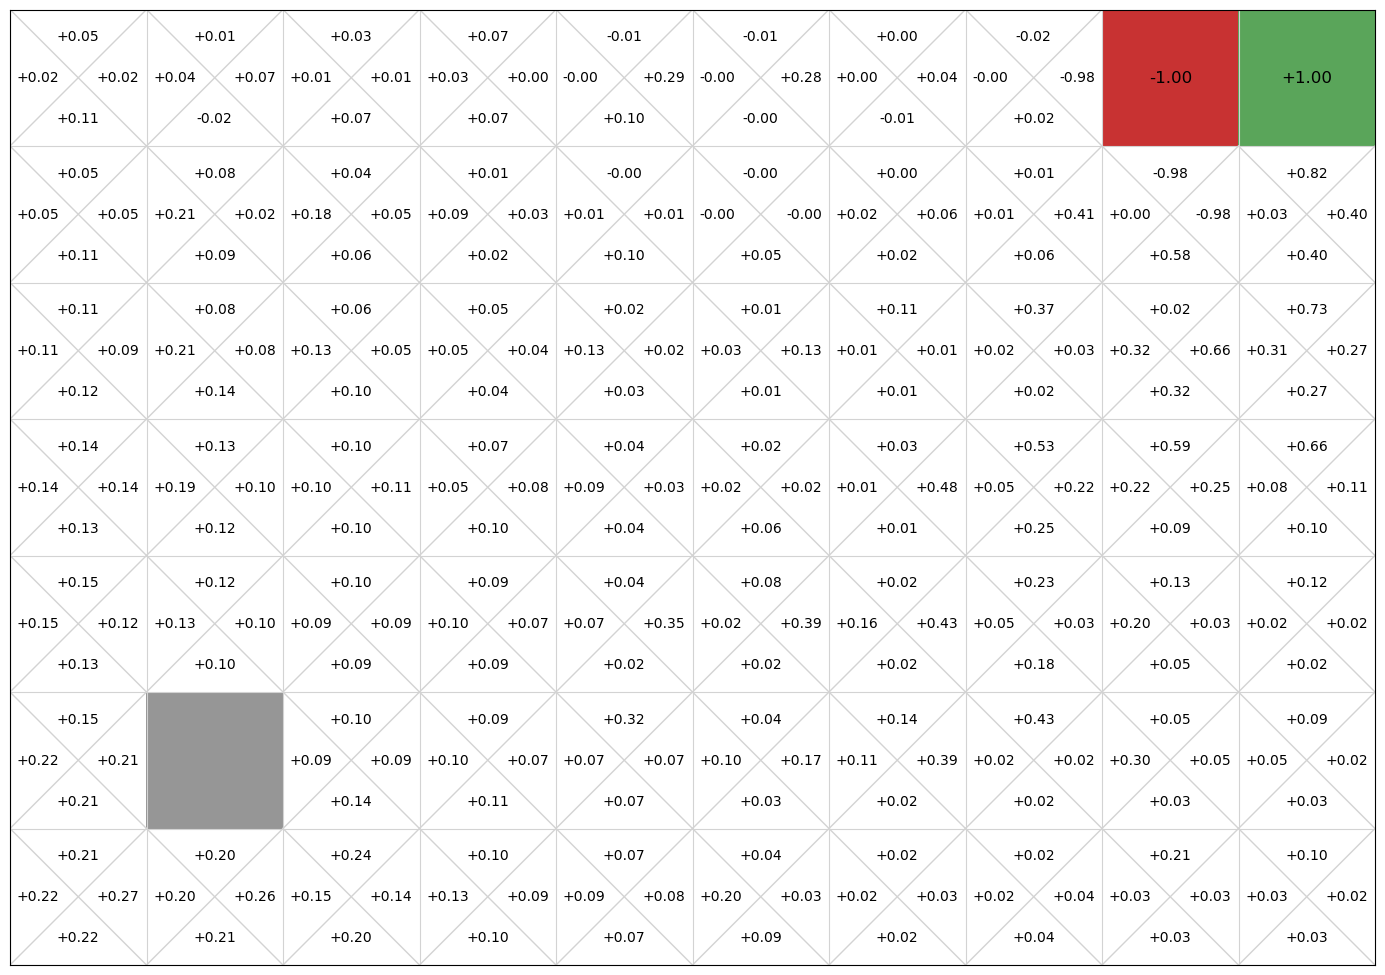

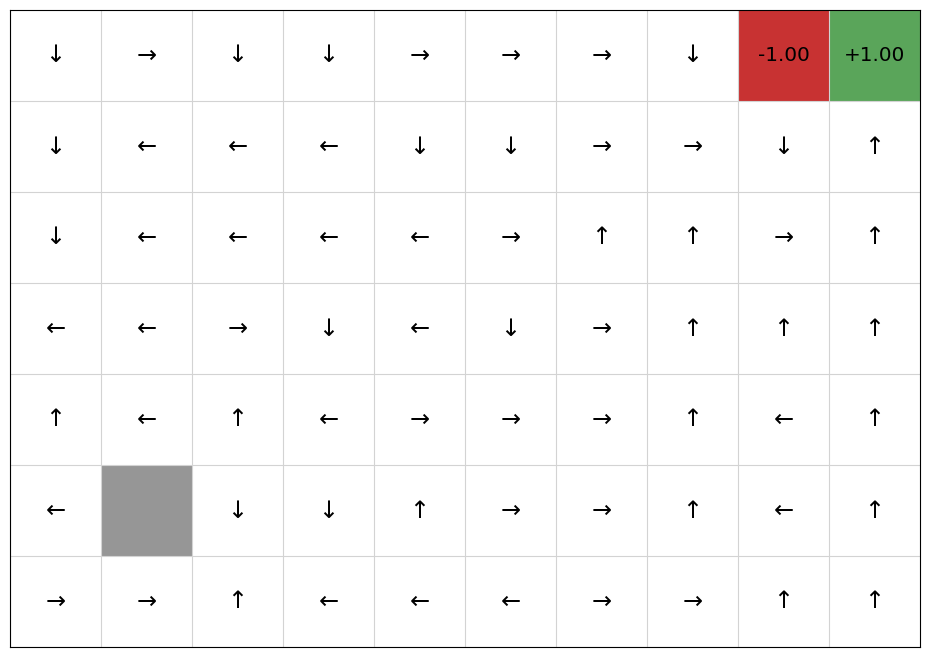

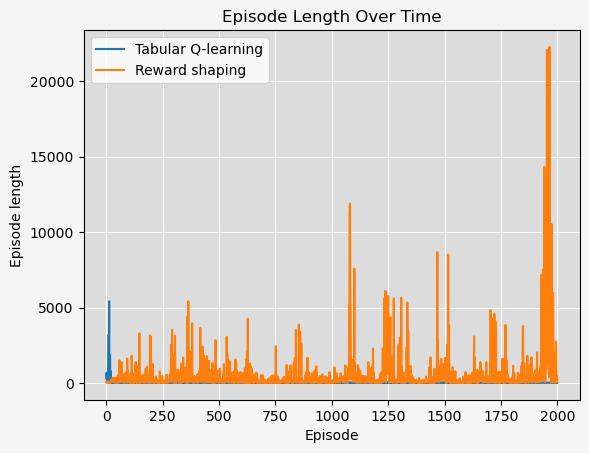

In [14]:
mdp = GridWorld(width = 10, height = 7, goals = [((9,6), 1), ((8,6), -1)])
qfunction = QTable()
tuning = NotAPotentialFunction(mdp)
RewardTunedQLearning(mdp, EpsilonGreedy(), tuning, qfunction).execute()
policy = qfunction.extract_policy(mdp)
mdp.visualise_q_function(qfunction)
mdp.visualise_policy(policy)
reward_shaped_rewards = mdp.get_rewards()

mdp = GridWorld(width = 10, height = 7, goals = [((9,6), 1), ((8,6), -1)])
qfunction = QTable()
QLearning(mdp, EpsilonGreedy(), qfunction).execute()
policy = qfunction.extract_policy(mdp)
q_learning_rewards = mdp.get_rewards()

Plot.plot_episode_length(
    ["Tabular Q-learning", "Reward shaping"],
    [q_learning_rewards, reward_shaped_rewards],
)

## A grid too large?
Is there a grid too large for the (unshaped) Q-learning agent to learn in 100 iterations? How does potential-based reward shaping fare?

In [15]:
from qtable import QTable
from qlearning import QLearning
from reward_shaped_qlearning import RewardShapedQLearning
from gridworld_potential_function import GridWorldPotentialFunction
from multi_armed_bandit.epsilon_greedy import EpsilonGreedy


mdp = GridWorld(width = 50, height = 50, goals = [((49,49), 1), ((48,49), -1)])
qfunction = QTable()
potential = GridWorldPotentialFunction(mdp)
RewardShapedQLearning(mdp, EpsilonGreedy(), potential, qfunction).execute()
# RewardShapedQLearning(mdp, EpsilonGreedy(), potential, qfunction).execute(visualize=True)
policy = qfunction.extract_policy(mdp)
reward_shaped_rewards = mdp.get_rewards()

mdp = GridWorld(width = 50, height = 50, goals = [((49,49), 1), ((48,49), -1)])
qfunction = QTable()
QLearning(mdp, EpsilonGreedy(), qfunction).execute()
policy = qfunction.extract_policy(mdp)
q_learning_rewards = mdp.get_rewards()

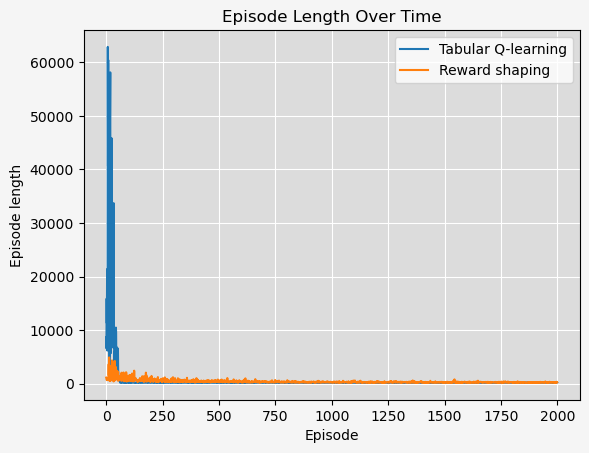

In [16]:
# from tests.plot import Plot

Plot.plot_episode_length(
    ["Tabular Q-learning", "Reward shaping"],
    [q_learning_rewards, reward_shaped_rewards],
)

<br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/>
